In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
dataPath = "A_Z Handwritten Data.csv"

Start with MNIST Data

In [2]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("mnist" in datasets_list) # is the dataset we're after available?

True


In [3]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(Num_train_data, Num_test_data, Num_valid_data), ds_info = tfds.load(name="mnist", # target dataset to get from TFDS
                                             split=["train[:90%]", "test", "train[90%:]"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [4]:
print("Train set size: ", len(Num_train_data)) 
print("Test set size: ", len(Num_test_data))  
print("Valid set size: ", len(Num_valid_data))  

Train set size:  54000
Test set size:  10000
Valid set size:  6000


In [5]:
Num_train_data

<_OptionsDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
class_names = ds_info.features["label"].names
class_names[:10]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [7]:
train_data_sample = Num_train_data.take(1)

In [8]:
for image, label in train_data_sample:
    print(f"""
    Image Shape: {image.shape},
    Image dtype: {image.dtype},
    Target class from (tensor form): {label}
    Class name (str form): {class_names[label]}
    """)


    Image Shape: (28, 28, 1),
    Image dtype: <dtype: 'uint8'>,
    Target class from (tensor form): 4
    Class name (str form): 4
    


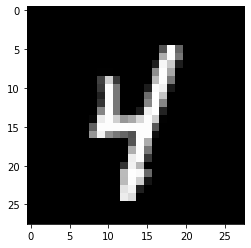

In [9]:
import matplotlib.pyplot as plt
plt.imshow(image ,cmap='gray')

In [10]:
def preprocess_img(image, label):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, label # return (float32_image, label) tuple

In [11]:
# Map preprocessing function to training data (and paralellize)
Num_train_data = Num_train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
Num_train_data = Num_train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
Num_test_data = Num_test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
Num_test_data = Num_test_data.batch(32).prefetch(tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
Num_valid_data = Num_valid_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
Num_valid_data = Num_valid_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
Num_train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Continue with AZ Datasets

In [13]:
def load_az_dataset(datasetPath):
    # List for storing data
    data = []
  
    # List for storing labels
    labels = []
  
    for row in open(datasetPath): #Openfile and start reading each row
    #Split the row at every comma
        row = row.split(",")
    
        #row[0] contains label
        label = int(row[0])
    
        #Other all collumns contains pixel values make a saperate array for that
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        
        #Reshaping image to 28 x 28 pixels
        image = image.reshape((28, 28))
        
        #append image to data
        data.append(image)
        
        #append label to labels
        labels.append(label)
    
    #Converting data to numpy array of type float32
    data = np.array(data, dtype='float32')
    data = np.expand_dims(data, axis=-1)
    #Converting labels to type int
    labels = np.array(labels, dtype="int64")
    
    return (data, labels)

In [14]:
az_data, az_labels = load_az_dataset(dataPath)

In [15]:
az_data.shape

(372451, 28, 28, 1)

In [16]:
(AZ_train_data_X, AZ_test_data_X, AZ_train_data_Y, AZ_test_data_Y) = train_test_split(az_data, az_labels, test_size=0.20, random_state=42)
(AZ_train_data_X, AZ_valid_data_X, AZ_train_data_Y, AZ_valid_data_Y) = train_test_split(AZ_train_data_X, AZ_train_data_Y, test_size=0.125, random_state=42)

In [17]:
AZ_train_data_X.shape, AZ_test_data_X.shape

((260715, 28, 28, 1), (74491, 28, 28, 1))

In [18]:
AZ_train_data_Y.shape, AZ_test_data_Y.shape

((260715,), (74491,))

In [19]:
AZ_valid_data_X.shape, AZ_valid_data_Y.shape

((37245, 28, 28, 1), (37245,))

In [20]:
AZ_train_data = tf.data.Dataset.from_tensor_slices((AZ_train_data_X, AZ_train_data_Y))
AZ_test_data = tf.data.Dataset.from_tensor_slices((AZ_test_data_X, AZ_test_data_Y))
AZ_valid_data = tf.data.Dataset.from_tensor_slices((AZ_valid_data_X, AZ_valid_data_Y))

In [21]:
AZ_train_data

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [22]:
AZ_train_data = AZ_train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
AZ_test_data = AZ_test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
AZ_valid_data = AZ_valid_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
AZ_train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [24]:
all_train_data = AZ_train_data.concatenate(Num_train_data)
all_test_data = AZ_test_data.concatenate(Num_test_data)
all_valid_data = AZ_valid_data.concatenate(Num_valid_data).shuffle(1000)

In [25]:
# Create base model
input_shape = (28, 28, 1)
input_t = tf.keras.Input(shape=(28,28,1))
res_model = tf.keras.applications.ResNet50(include_top=False,
                                              weights=None,
                                              input_tensor=input_t)

In [26]:
# Create Functional model  
inputs = layers.Input(shape=(28,28,1), name="input_layer")
x = res_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(36)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
model = tf.keras.Model(inputs, outputs)

# Compile our resnet model
model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=["accuracy"])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", # watch the val loss metric
                                                  patience=10,
                                                  min_delta=0.0001,) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "OCR_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [27]:
# Fit the model
history=model.fit(all_train_data,
                  epochs=10,
                  validation_data=all_test_data,
                  callbacks=[model_checkpoint,
                             early_stopping, 
                             reduce_lr])

Epoch 1/10
9836/9836 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9330INFO:tensorflow:Assets written to: OCR_checkpoints\assets


INFO:tensorflow:Assets written to: OCR_checkpoints\assets


9836/9836 [==============================] - 739s 74ms/step - loss: 0.2440 - accuracy: 0.9330 - val_loss: 192.2944 - val_accuracy: 0.1805 - lr: 0.0010
Epoch 2/10
9836/9836 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9618INFO:tensorflow:Assets written to: OCR_checkpoints\assets


INFO:tensorflow:Assets written to: OCR_checkpoints\assets


9836/9836 [==============================] - 726s 74ms/step - loss: 0.1655 - accuracy: 0.9618 - val_loss: 1.6051 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 3/10
9836/9836 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9722INFO:tensorflow:Assets written to: OCR_checkpoints\assets


INFO:tensorflow:Assets written to: OCR_checkpoints\assets


9836/9836 [==============================] - 727s 74ms/step - loss: 0.1089 - accuracy: 0.9722 - val_loss: 1.4010 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 4/10
9836/9836 [==============================] - 712s 72ms/step - loss: 0.0903 - accuracy: 0.9768 - val_loss: 13.3571 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 5/10
9836/9836 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9796
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
9836/9836 [==============================] - 714s 73ms/step - loss: 0.0788 - accuracy: 0.9796 - val_loss: 4.6070 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 6/10
9836/9836 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9902INFO:tensorflow:Assets written to: OCR_checkpoints\assets


INFO:tensorflow:Assets written to: OCR_checkpoints\assets


9836/9836 [==============================] - 732s 74ms/step - loss: 0.0373 - accuracy: 0.9902 - val_loss: 0.0441 - val_accuracy: 0.9891 - lr: 2.0000e-04
Epoch 7/10
9836/9836 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9936INFO:tensorflow:Assets written to: OCR_checkpoints\assets


INFO:tensorflow:Assets written to: OCR_checkpoints\assets


9836/9836 [==============================] - 733s 75ms/step - loss: 0.0232 - accuracy: 0.9936 - val_loss: 0.0399 - val_accuracy: 0.9912 - lr: 2.0000e-04
Epoch 8/10
9836/9836 [==============================] - 715s 73ms/step - loss: 0.0170 - accuracy: 0.9953 - val_loss: 0.0401 - val_accuracy: 0.9919 - lr: 2.0000e-04
Epoch 9/10
9836/9836 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9960
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
9836/9836 [==============================] - 715s 73ms/step - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.0414 - val_accuracy: 0.9916 - lr: 2.0000e-04
Epoch 10/10
9836/9836 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980INFO:tensorflow:Assets written to: OCR_checkpoints\assets


INFO:tensorflow:Assets written to: OCR_checkpoints\assets


9836/9836 [==============================] - 733s 74ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0392 - val_accuracy: 0.9939 - lr: 4.0000e-05


In [29]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

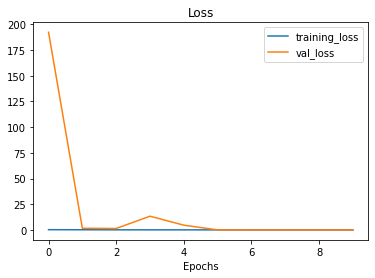

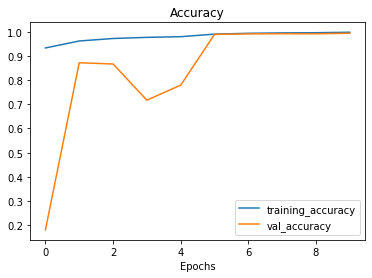

In [30]:
plot_loss_curves(history)

In [32]:
# Evaluate model on whole test dataset
results_model = model.evaluate(all_valid_data)
results_model

1352/1352 [==============================] - 28s 20ms/step - loss: 0.0431 - accuracy: 0.9932


[0.04307640716433525, 0.9932477474212646]